In [1]:
# Advanced Data Analytics Final Project
# Aaron Forrest, Ajay Parthasarathy, Grant Tilson
# 5/3/21

## Need to pip install import_ipynb to get this functionality
## Meant to give access to other .ipynb notebooks to use as modules
## Must also create a blank file in this folder titled '__init__.ipynb'
import import_ipynb

In [2]:
# Helpful Links
# https://towardsdatascience.com/random-forest-in-python-24d0893d51c0
# https://www.datacamp.com/community/tutorials/random-forests-classifier-python
# https://stackabuse.com/random-forest-algorithm-with-python-and-scikit-learn/
# https://www.kaggle.com/janiobachmann/credit-fraud-dealing-with-imbalanced-datasets
# https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/
# https://www.kaggle.com/kabure/credit-card-fraud-prediction-rf-smote

In [3]:
# Track time to test HPC
import time
start_time=time.time()

In [4]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, fbeta_score, precision_recall_curve
from sklearn.preprocessing import RobustScaler
from scipy import stats

In [5]:
# SMOTE imports
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import EditedNearestNeighbours

In [6]:
# Import Other Files
# Must compile the other two files of the same name prior to running this block
import GeneratePlots
import Random_Forest

importing Jupyter notebook from GeneratePlots.ipynb
importing Jupyter notebook from Random_Forest.ipynb


In [7]:
# Create name for text file that will store Random Forest Run Results
random_forest_file_name="Random_Forest_Results.txt"

# Truncate them to clear their previous contents 
random_forest_file=open(random_forest_file_name,"a")
random_forest_file.truncate(0)
random_forest_file.close()

In [8]:
# Set plotting style
plt.style.use('ggplot')

In [9]:
# Import credit card transaction data
df_creditcard = pd.read_csv('creditcard.csv')

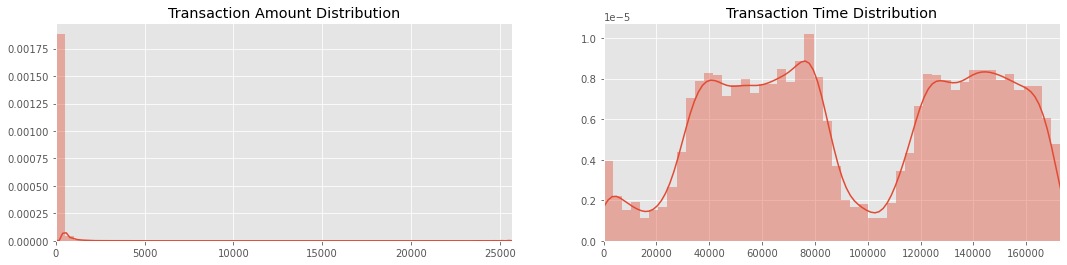

In [10]:
# Generate plots of transaction amount and time distributions
GeneratePlots.gen_amount_time_plot(df_creditcard)

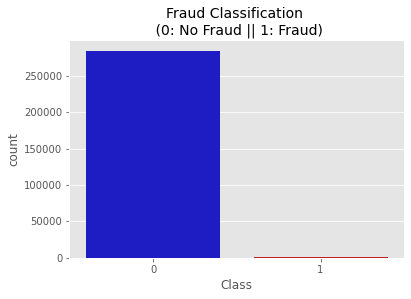

In [11]:
# Generate plot showing initial ratio of Fraud to No Fraud cases
GeneratePlots.gen_data_class(df_creditcard)

In [12]:
# The V* features are scaled but the Time and Amount features are not scaled
# This scales those two features for proper analysis
robust_scaler=RobustScaler()

# Scale new values
df_creditcard['Amount_Scaled']=robust_scaler.fit_transform(df_creditcard['Amount'].values.reshape(-1,1))
df_creditcard['Time_Scaled']=robust_scaler.fit_transform(df_creditcard['Time'].values.reshape(-1,1))

# Drop old time and amount features
df_creditcard.drop(['Time','Amount'], axis=1, inplace=True)

In [13]:
# Need to rearrange order of columns to make sure that Class is the last column
scaled_amount_placeholder=df_creditcard['Amount_Scaled']
scaled_time_placeholder=df_creditcard['Time_Scaled']
df_creditcard.drop(['Amount_Scaled','Time_Scaled'], axis=1, inplace=True)
df_creditcard.insert(0,'Amount_Scaled',scaled_amount_placeholder)
df_creditcard.insert(1,'Time_Scaled',scaled_time_placeholder)

In [14]:
# Split Data into test and train datasets
# X values are V* and Amount and Y values are 1 for fraud and 0 for not fraud
# Current Train dataset is 70% of the total dataset
X=df_creditcard.iloc[:,0:30]
y=df_creditcard.iloc[:,30]
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=.3)

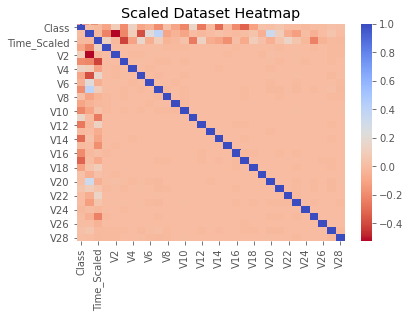

In [15]:
# Run of the random forest model using scaled dataset
Random_Forest.random_forest(df_creditcard, X_train, X_test, y_train, y_test,"Scaled", random_forest_file_name)

In [16]:
# Oversample the Fraud cases in the training dataset
# This uses the SMOTE method and causes the dataset to be perfectly balanced between Fraud and No Fraud cases
OS=SMOTE()
X_train_os,y_train_os=OS.fit_resample(X_train,y_train)

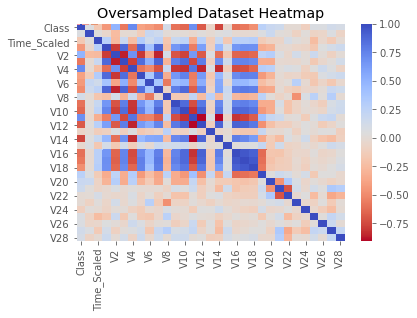

In [17]:
# Run of random forest model using oversampled training data
Random_Forest.random_forest(df_creditcard, X_train_os, X_test, y_train_os, y_test,"Oversampled", random_forest_file_name)

In [18]:
# Randomly Undersample the Not Fraud cases
# Randomly remove cases from the majority dataset until there is an even number of cases
# This case undersamples until there is an even number of fraud and no fraud cases
under = RandomUnderSampler(sampling_strategy=1)
steps = [('u', under)]
pipeline = Pipeline(steps=steps)
# transform the dataset
X_train_us, y_train_us = pipeline.fit_resample(X_train, y_train)

# This case randomly undersamples until there are 4 times as many Not Frauds as there are Frauds
under = RandomUnderSampler(sampling_strategy=.25)
steps = [('u', under)]
pipeline = Pipeline(steps=steps)
# transform the dataset
X_train_us_4, y_train_us_4 = pipeline.fit_resample(X_train, y_train)

In [19]:
# This method uses TomekLinks to undersample the No Fraud cases
# This will not balance the transformed dataset, but it will help decrease ambigiuity along the class boundary
undersample_tomek=TomekLinks()
X_train_tomek,y_train_tomek = undersample_tomek.fit_resample(X_train,y_train)

In [20]:
# This method uses Edited Nearest Neighbours to undersample No Fraud cases
# This will not balance the transformed dataset, but it will help decrease ambigiuity along the class boundary
undersample_ENN=EditedNearestNeighbours(n_neighbors=3)
X_train_ENN,y_train_ENN=undersample_ENN.fit_resample(X_train,y_train)

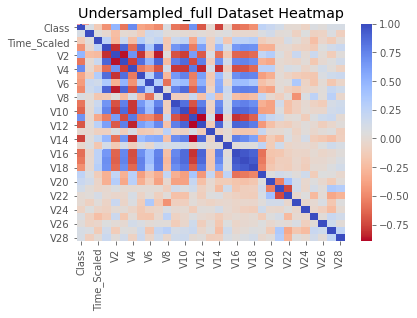

In [21]:
# Run of random forest model using undersampled training data
Random_Forest.random_forest(df_creditcard, X_train_us, X_test, y_train_us, y_test,"Undersampled_full", random_forest_file_name)

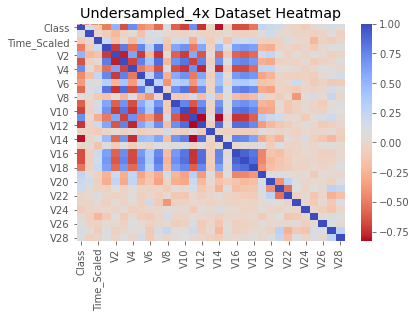

In [22]:
# Run of random forest model using undersampled 4x training data
Random_Forest.random_forest(df_creditcard, X_train_us_4, X_test, y_train_us_4, y_test,"Undersampled_4x", random_forest_file_name)

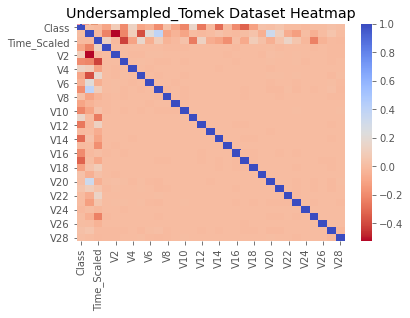

In [23]:
# Use TomekLinks to undersample the No Fraud Cases
# Run of random forest model using tomek undersampled training data
Random_Forest.random_forest(df_creditcard, X_train_tomek, X_test, y_train_tomek, y_test,"Undersampled_Tomek", random_forest_file_name)

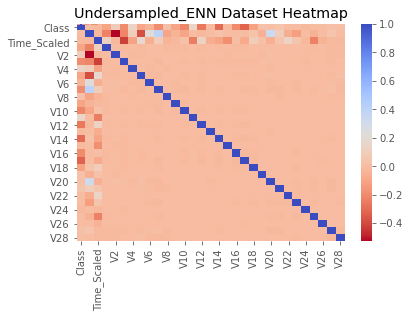

In [24]:
# Use Edited Nearest Neighbours to undersample the No Fraud Cases
# Run of random forest model using ENN undersampled training data
Random_Forest.random_forest(df_creditcard, X_train_ENN, X_test, y_train_ENN, y_test,"Undersampled_ENN", random_forest_file_name)

In [25]:
# Pipeline over and undersample to see mixed results
over = SMOTE(sampling_strategy=0.5)
#under = RandomUnderSampler(sampling_strategy=1)
under = EditedNearestNeighbours(n_neighbors=3)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
# transform the dataset
X_train_os_us, y_train_os_us = pipeline.fit_resample(X_train, y_train)

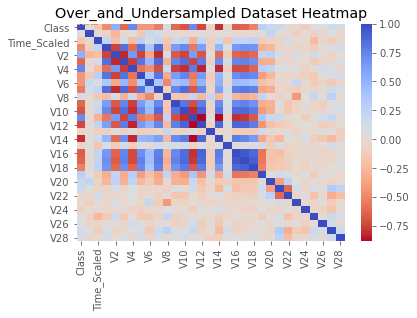

In [26]:
# Run of random forest model using over and under sampled training data
Random_Forest.random_forest(df_creditcard, X_train_os_us, X_test, y_train_os_us, y_test,"Over_and_Undersampled", random_forest_file_name)

In [27]:
print(str(round((time.time()-start_time)/60,1))+' minutes')

36.1 minutes
